In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
# Carregar o conjunto de dados
df = pd.read_csv("../data/commerce_dataset_clean.csv", sep=";")

In [11]:
# Converter a coluna 'dtme' para datetime e definir como índice do DataFrame
df["dtme"] = pd.to_datetime(df["dtme"])
df.set_index("dtme", inplace=True)

## SARIMA


In [12]:
# Agregar os dados para obter o total de vendas por dia
daily_sales = df["total"].resample("D").sum()

# Dividir os dados em conjunto de treinamento (20%) e teste (80%)
split_point = int(len(daily_sales) * 0.2)
train_data, test_data = daily_sales[:split_point], daily_sales[split_point:]

# Exibir as primeiras linhas do conjunto de treinamento e teste para verificação
train_data.head(), test_data.head(), len(train_data), len(test_data)

(dtme
 2019-01-01    4745.1810
 2019-01-02    1945.5030
 2019-01-03    2078.1285
 2019-01-04    1623.6885
 2019-01-05    3536.6835
 Freq: D, Name: total, dtype: float64,
 dtme
 2019-01-18    2780.4735
 2019-01-19    4914.7245
 2019-01-20    3655.4490
 2019-01-21    2392.0995
 2019-01-22    1704.7695
 Freq: D, Name: total, dtype: float64,
 17,
 72)

In [13]:
# # Metodo old
# import itertools
# import math
# import statsmodels.api as sm
# import warnings

# warnings.filterwarnings("ignore")

# # Define the range of values for p, d, q, P, D, Q, and m
# p_values = range(0, 3)  # Autoregressive order
# d_values = [0]          # Differencing order
# q_values = range(0, 3)  # Moving average order
# P_values = range(0, 2)  # Seasonal autoregressive order
# D_values = range(0, 1)  # Seasonal differencing order
# Q_values = range(0, 2)  # Seasonal moving average order
# m_values = [12]         # Seasonal period

# # Create all possible combinations of SARIMA parameters
# param_combinations = list(itertools.product(p_values,
#                                             d_values,
#                                             q_values,
#                                             P_values,
#                                             D_values,
#                                             Q_values,
#                                             m_values))

# # Initialize AIC with a large value
# best_aic = float("inf")
# best_params = None

# # Perform grid search
# for params in param_combinations:
#     order = params[:3]
#     seasonal_order = params[3:]

#     try:
#         model = sm.tsa.SARIMAX(train_data,
#                                order=order,
#                                seasonal_order=seasonal_order)
#         result = model.fit(disp=False)
#         aic = result.aic

#         # Ensure the convergence of the model
#         if not math.isinf(result.zvalues.mean()):
#             print(order, seasonal_order, aic)

#             if aic < best_aic:
#                 best_aic = aic
#                 best_params = params

#         else:
#             print(order, seasonal_order, 'not converged')

#     except:
#         continue

# # Print the best parameters and AIC
# print("Best Parameters:", best_params)
# print("Best AIC:", best_aic)

In [14]:
import itertools
import math
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

"""
S -> Seasonal
AR -> Autoregressive
I -> Integrated
MA -> Moving Average
"""

"""
Processo:
1. Definir os intervalos para os parâmetros SARIMA: p (ordem autoregressiva), d (ordem de diferenciação), q (ordem de média móvel), P (ordem autoregressiva sazonal), D (ordem de diferenciação sazonal), Q (ordem de média móvel sazonal) e m (período sazonal).
2. Gerar todas as possíveis combinações desses parâmetros.
3. Inicializar o melhor escore AIC (Critério de Informação de Akaike) como infinito e preparar para rastrear o melhor conjunto de parâmetros.
4. Iterar através de cada combinação de parâmetros, ajustando um modelo SARIMAX aos dados de treinamento com esses parâmetros.
5. Calcular o AIC para cada modelo. Se o modelo convergir (verificado através da média dos valores-z não sendo infinito) e o AIC for menor que o melhor atual, atualizar o melhor AIC e parâmetros.
6. Imprimir os melhores parâmetros e seu respectivo escore AIC.
"""

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [1]  # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]  # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(
    itertools.product(
        p_values, d_values, q_values, P_values, D_values, Q_values, m_values
    )
)

# Initialize AIC with a large value
best_aic = float("inf")
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = sm.tsa.SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            if aic < best_aic:
                best_aic = aic
                best_params = params

    except ValueError:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

Best Parameters: (0, 1, 1, 1, 0, 0, 12)
Best AIC: 274.7597791989864


In [15]:
# Definir parâmetros iniciais para o modelo SARIMA
# Estes parâmetros podem precisar de ajuste baseado em diagnósticos do modelo ou conhecimento do domínio

# Non-seasonal components
p, d, q = 1, 1, 1
# p: The order of the autoregressive part of the model.
# d: The degree of first differencing involved.
# q: The order of the moving average part of the model.

# Seasonal components
# P, D, Q, m = 1, 1, 2, 7
P, D, Q, m = 2, 1, 1, 7
# P: The order of the seasonal autoregressive part of the model.
# D: The degree of first differencing involved in the seasonal part of the model.
# Q: The order of the seasonal moving average part of the model.
# m: The number of time steps for a single seasonal period.

# Construir e treinar o modelo SARIMA com o conjunto de treinamento
model_sarima = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_sarima_fit = model_sarima.fit(disp=False)

# Resumo do modelo
print(model_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             total   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood                   0.000
Date:                           Wed, 28 Feb 2024   AIC                             12.000
Time:                                   13:57:27   BIC                             13.183
Sample:                               01-01-2019   HQIC                             9.446
                                    - 01-17-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9984   3.77e-08  -2.64e+07      0.000      -0.998      -0.998
ma.L1         -0.5434   2.93e-08  -1.85e+07

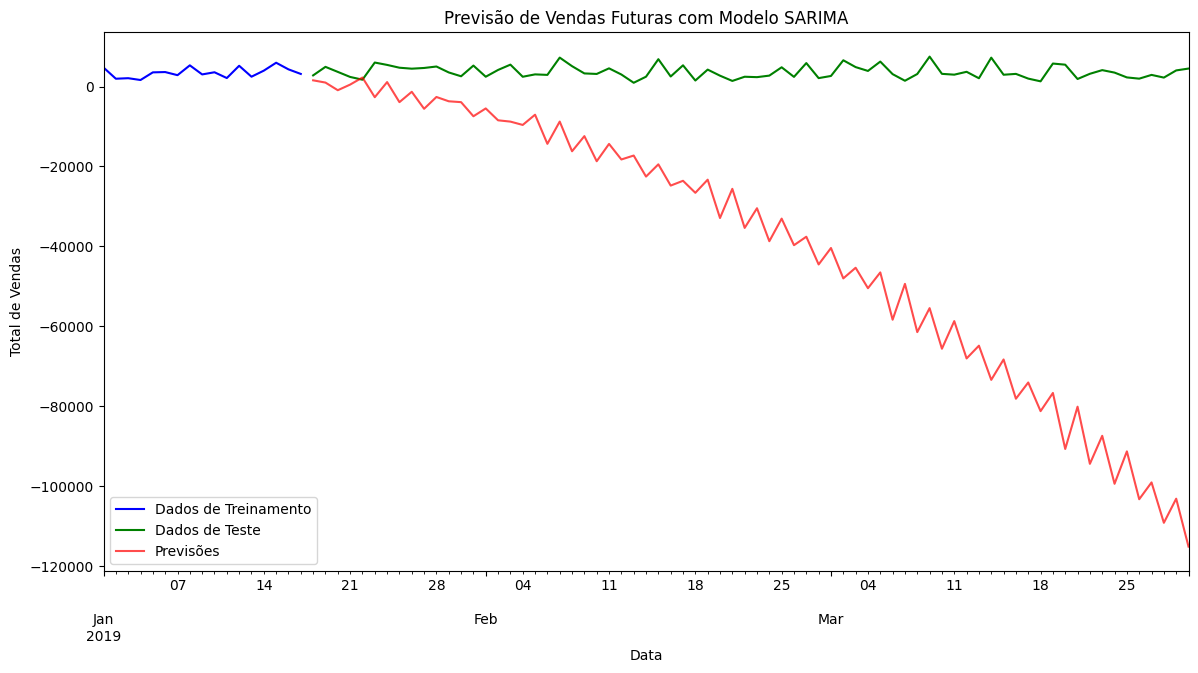

In [16]:
# Realizar previsões no conjunto de teste
forecast = model_sarima_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotar as previsões juntamente com os dados reais
plt.figure(figsize=(14, 7))
train_data.plot(label="Dados de Treinamento", color="blue")
test_data.plot(label="Dados de Teste", color="green")
forecast_mean.plot(label="Previsões", color="red", alpha=0.7)
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="pink",
    alpha=0.3,
)
plt.title("Previsão de Vendas Futuras com Modelo SARIMA")
plt.xlabel("Data")
plt.ylabel("Total de Vendas")
plt.legend()
plt.show()